
# Prefill (Encode) Time Estimates for Transformers — A100‑40GB (2·m·n·p convention)

This notebook derives and visualizes **prefill** (encode) time across $S$ concurrent requests,
counting matmuls as **$2mnp$ FLOPs**.

It includes:
- Compute and memory time formulas (with inline math in $...$).
- Parameters for NVIDIA **A100‑40GB**.
- Functions for $T_{prefill}^{compute}(S,L)$ and $T_{prefill}^{memory}(S,L)$.
- Plots vs $L$ and vs $S$.



## Formulas

**Compute FLOPs per layer & request (length $L$):**
- Projections $Q,K,V,O$: $8Ld^2$
- Attention ($QK^T$ and $AV$): $4L^2d$
- FFN: $4rLd^2$

So  
$FLOPs_{layer,req} = (8+4r)Ld^2 + 4L^2d$

Across $S$ requests and $n_\ell$ layers:  
$T_{prefill}^{compute}(S,L) = \dfrac{n_\ell S((8+4r)Ld^2 + 4L^2d)}{GPU\ FLOPs/s}$

---

**Memory traffic per prefill round:**
1. Weights read: $n_\ell(4+2r)d^2 \times dtype\_bytes$  
2. KV write: $n_\ell(2SLd) \times dtype\_bytes$  
3. Activations: $n_\ell(c_{act}SLd) \times dtype\_bytes$

Total bytes:  
$n_\ell((4+2r)d^2 + (2+c_{act})SLd) \cdot dtype\_bytes$

So  
$T_{prefill}^{memory}(S,L) = \dfrac{n_\ell((4+2r)d^2 + (2+c_{act})SLd) \cdot dtype\_bytes}{BW}$



## Parameters (A100‑40GB)

- Hidden size $d = 4096$  
- FFN expansion $r = 4$  
- Layers $n_\ell = 64$  
- dtype\_bytes = 2 (FP16/BF16)  
- GPU peak FLOPs/s = $312 \times 10^{12}$  
- Bandwidth $BW \approx 1.555 \times 10^{12}$ Bytes/s (≈1555 GB/s)  


In [1]:

r = 4
d = 4096
n_layers = 64
dtype_bytes = 2
gpu_flops_per_sec = 312e12
BW = 1.555e12
c_act = 12


## Functions

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def T_prefill_compute(S, L, d=d, r=r, n_layers=n_layers, gpu=gpu_flops_per_sec):
    flops_layer_req = (8 + 4*r) * L * d**2 + 4 * L**2 * d
    total_flops = flops_layer_req * S * n_layers
    return total_flops / gpu

def T_prefill_memory(S, L, d=d, r=r, n_layers=n_layers, dtype_bytes=dtype_bytes, BW=BW, c_act=c_act):
    bytes_total = (
        n_layers * (4 + 2*r) * d**2 * dtype_bytes +
        n_layers * (2 + c_act) * S * L * d * dtype_bytes
    )
    return bytes_total / BW


## Plots vs $L$ for various $S$

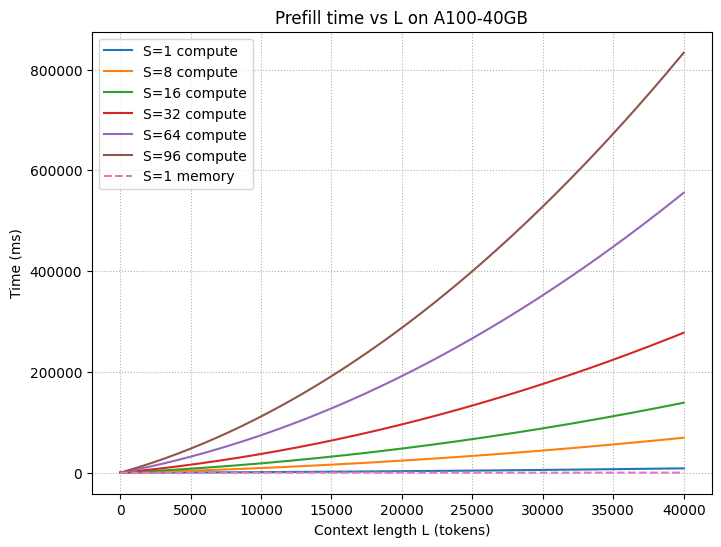

In [3]:

L_vals = np.linspace(1, 40000, 400)
S_list = [1, 8, 16, 32, 64, 96]

plt.figure(figsize=(8,6))
for S in S_list:
    Tcomp = [T_prefill_compute(S, L) * 1e3 for L in L_vals]
    plt.plot(L_vals, Tcomp, label=f'S={S} compute')
Tmem = [T_prefill_memory(1, L) * 1e3 for L in L_vals]
plt.plot(L_vals, Tmem, '--', label='S=1 memory')
plt.xlabel("Context length L (tokens)")
plt.ylabel("Time (ms)")
plt.title("Prefill time vs L on A100-40GB")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


## Plots vs $S$ for fixed $L$

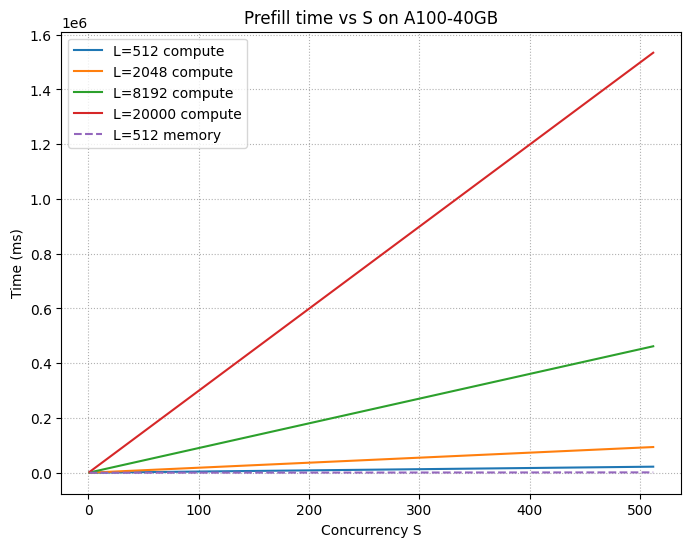

In [4]:

S_vals = np.linspace(1, 512, 200)
L_list = [512, 2048, 8192, 20000]

plt.figure(figsize=(8,6))
for L in L_list:
    Tcomp = [T_prefill_compute(S, L) * 1e3 for S in S_vals]
    plt.plot(S_vals, Tcomp, label=f'L={L} compute')
Tmem = [T_prefill_memory(S, 512) * 1e3 for S in S_vals]
plt.plot(S_vals, Tmem, '--', label='L=512 memory')
plt.xlabel("Concurrency S")
plt.ylabel("Time (ms)")
plt.title("Prefill time vs S on A100-40GB")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


## Sanity Check Table

In [5]:

rows = []
for (S, L) in [(1, 1024), (8, 1024), (32, 2048), (64, 8192), (128, 20000)]:
    rows.append({
        "S": S,
        "L": L,
        "T_compute_ms": T_prefill_compute(S, L) * 1e3,
        "T_memory_ms": T_prefill_memory(S, L) * 1e3
    })
df = pd.DataFrame(rows)
df


,S,L,T_compute_ms,T_memory_ms
0,1,1024,88.101893,21.405786
1,8,1024,704.815146,55.240737
2,32,2048,5864.062015,325.920348
3,64,8192,57738.456761,2491.357235
4,128,20000,383518.554059,12100.483424
